# MNIST Notebook

## Original Model Definition

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.li = nn.Linear(28*28,64)
        self.l1 = nn.Linear(64,64)
        self.lf = nn.Linear(64,10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.li(x))
        x = torch.relu(self.l1(x))
        x = self.lf(x)
        return x
        
model = SimpleNN()

In [4]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    model.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
        
      #train_losses.append(loss.item())
      #train_counter.append(
      #  (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def validate():
    model.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [6]:
criteria = nn.CrossEntropyLoss()
#criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.303125
Train Epoch: 0 [23936/48000 (50%)]	Loss: 0.298005
Train Epoch: 0 [47872/48000 (100%)]	Loss: 0.084346

Validation Set Accuracy: 11216/12000 (93.47%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.202811
Train Epoch: 1 [23936/48000 (50%)]	Loss: 0.252623
Train Epoch: 1 [47872/48000 (100%)]	Loss: 0.180136

Validation Set Accuracy: 11398/12000 (94.98%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.125491
Train Epoch: 2 [23936/48000 (50%)]	Loss: 0.115853
Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.167211

Validation Set Accuracy: 11505/12000 (95.88%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.022812
Train Epoch: 3 [23936/48000 (50%)]	Loss: 0.108911
Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.050204

Validation Set Accuracy: 11520/12000 (96.00%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.139176
Train Epoch: 4 [23936/48000 (50%)]	Loss: 0.099522
Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.090639

Validation Set Accuracy: 11586/12000 (96.55%)

Train Epoch: 5 [0/48000 (0%)]	

In [7]:
def test(network, criteria):
    network.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = network(images)
            test_loss += criteria(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 0100. * correct / len(test_loader.dataset)))

torch.save(model.state_dict() , './models/MNIST/original_model.pth')
test(model, criteria)


Test set: Avg. loss: 0.001512, Accuracy: 9733/10000 (97.33%)



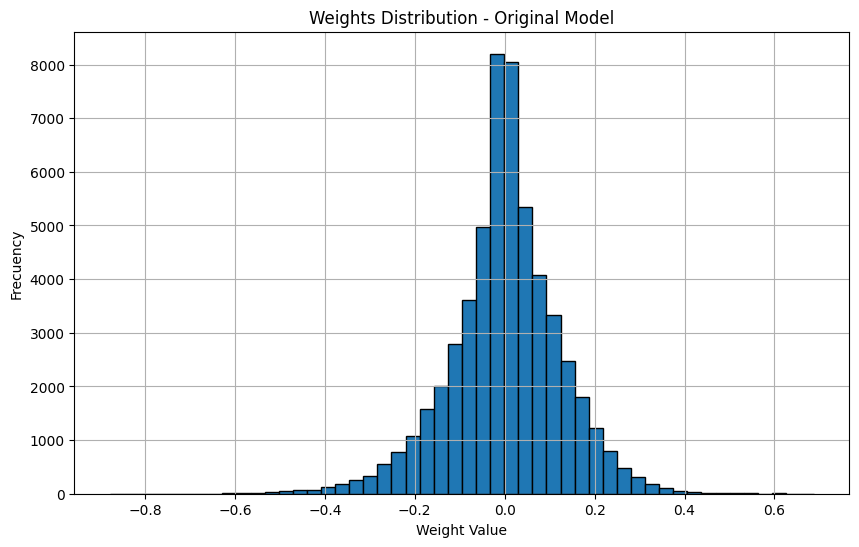

In [8]:
def show_weights(network, name):
    weights = []
    for param in network.parameters():
        if param.requires_grad:
            weights.extend(param.detach().cpu().numpy().flatten())
    
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=50, edgecolor='black')
    plt.title('Weights Distribution - {}'.format(name))
    plt.xlabel('Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_weights(model,"Original Model")

## Pytorch Post-Training Quantization (8 bits)

In [9]:
ptq_model_8bit = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
torch.save(ptq_model_8bit.state_dict(), './models/MNIST/ptq_model_8bit.pth')

In [10]:
float_model_size = os.path.getsize('./models/MNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/MNIST/ptq_model_8bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 0.213MB
Quantized model: 0.057MB


In [11]:
test(ptq_model_8bit, criteria)


Test set: Avg. loss: 0.001512, Accuracy: 9735/10000 (97.35%)



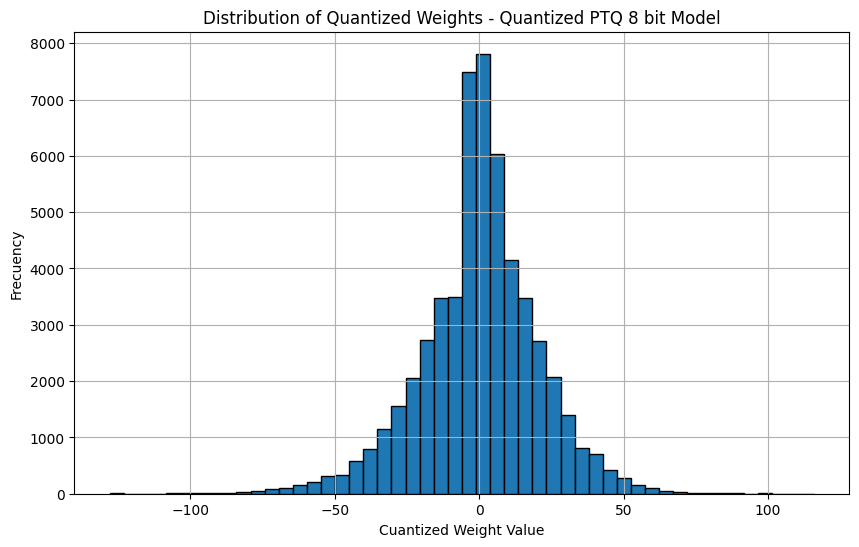

In [12]:
def show_quantized_weights(network, title):
    weights = []
    for name, module in network.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=50, edgecolor='black')
    plt.title('Distribution of Quantized Weights - {}'.format(title))
    plt.xlabel('Cuantized Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_quantized_weights(ptq_model_8bit,"Quantized PTQ 8 bit Model")

## Pytorch Quantization Aware Training (8 bits)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [13]:
class QuantAwareNN(nn.Module):
    def __init__(self):
        super(QuantAwareNN, self).__init__()
        self.quant = quantization.QuantStub()
        self.li = nn.Linear(28*28,64)
        self.l1 = nn.Linear(64,64)
        self.lf = nn.Linear(64,10)
        self.dequant = quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = x.view(-1, 28*28)
        x = torch.relu(self.li(x))
        x = torch.relu(self.l1(x))
        x = self.lf(x)
        x = self.dequant(x)
        return x

In [14]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
qat_model_8bit = QuantAwareNN()

qat_model_8bit.train()
qat_model_8bit.qconfig = quantization.get_default_qat_qconfig('x86')
qat_model_8bit = quantization.prepare_qat(qat_model_8bit)

/home/brais.martinez/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [16]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    qat_model_8bit.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = qat_model_8bit(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

def validate():
    qat_model_8bit.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = qat_model_8bit(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [17]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model_8bit.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.323502
Train Epoch: 0 [23936/48000 (50%)]	Loss: 0.235034
Train Epoch: 0 [47872/48000 (100%)]	Loss: 0.185328

Validation Set Accuracy: 11251/12000 (93.76%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.205795
Train Epoch: 1 [23936/48000 (50%)]	Loss: 0.114294
Train Epoch: 1 [47872/48000 (100%)]	Loss: 0.173728

Validation Set Accuracy: 11479/12000 (95.66%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.161925
Train Epoch: 2 [23936/48000 (50%)]	Loss: 0.243290
Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.193744

Validation Set Accuracy: 11518/12000 (95.98%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.049455
Train Epoch: 3 [23936/48000 (50%)]	Loss: 0.056656
Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.101372

Validation Set Accuracy: 11579/12000 (96.49%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.067981
Train Epoch: 4 [23936/48000 (50%)]	Loss: 0.023018
Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.077192

Validation Set Accuracy: 11623/12000 (96.86%)

Train Epoch: 5 [0/48000 (0%)]	

In [18]:
qat_model_8bit.eval()
qat_model_8bit = quantization.convert(qat_model_8bit)

torch.save(qat_model_8bit.state_dict() , './models/MNIST/qat_model_8bit.pth')
test(qat_model_8bit, criteria)


Test set: Avg. loss: 0.001511, Accuracy: 9725/10000 (97.25%)



In [19]:
float_model_size = os.path.getsize('./models/MNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/MNIST/qat_model_8bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 0.213MB
Quantized model: 0.061MB


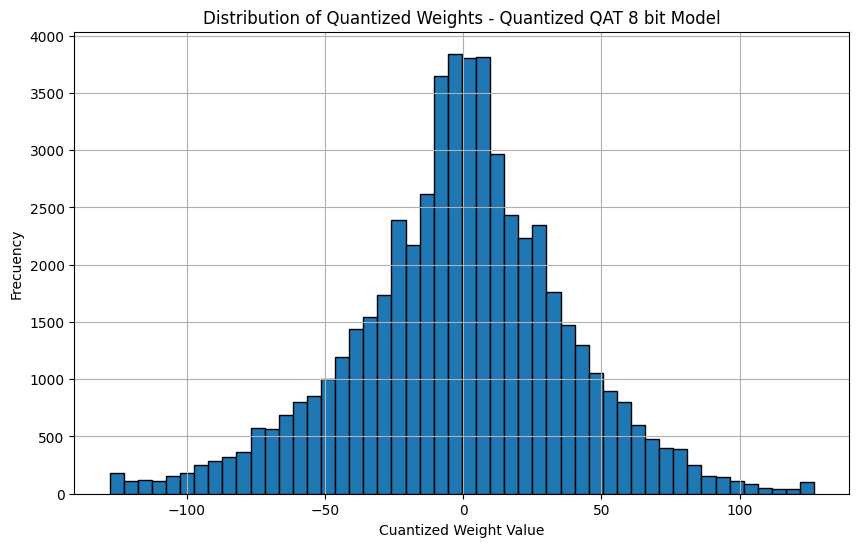

In [20]:
show_quantized_weights(qat_model_8bit,"Quantized QAT 8 bit Model")

## Post-Training Quantization propio (4 bits) (simulados)

Este apartado simula una quantización, pero no es capaz de hacerla completamente, por lo que no se experimenta una verdadera reducción de tamaño

In [21]:
def quantize_weights(tensor, bits):
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val) / ((2**bits)- 1)
    quantized_tensor = torch.round((tensor) / scale)
    return quantized_tensor

def quantize_model(model, bits = 4):
    quantized_model = SimpleNN()
    for name, param in model.named_parameters():
        if 'weight' in name:
            quantized_param = quantize_weights(param.data, bits)
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            if isinstance(getattr(layer, param_type), torch.Tensor):
                setattr(layer, param_type, nn.Parameter(quantized_param))
            else:
                raise ValueError(f"Expected {param_type} to be a tensor, but got {type(getattr(layer, param_type))} instead.")
        else:
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            setattr(layer, param_type, nn.Parameter(param.data))

    return quantized_model

Quizas el punto que me falta es recuperar el factor de escala

PD: Igual tambien tendria que gestionar los bias

In [22]:
ptq_model_4bit = quantize_model(model,4)

torch.save(ptq_model_4bit.state_dict(), 'models/MNIST/ptq_model_4bit_sim.pth')
test(ptq_model_4bit, criteria)


Test set: Avg. loss: 1.480065, Accuracy: 9683/10000 (96.83%)



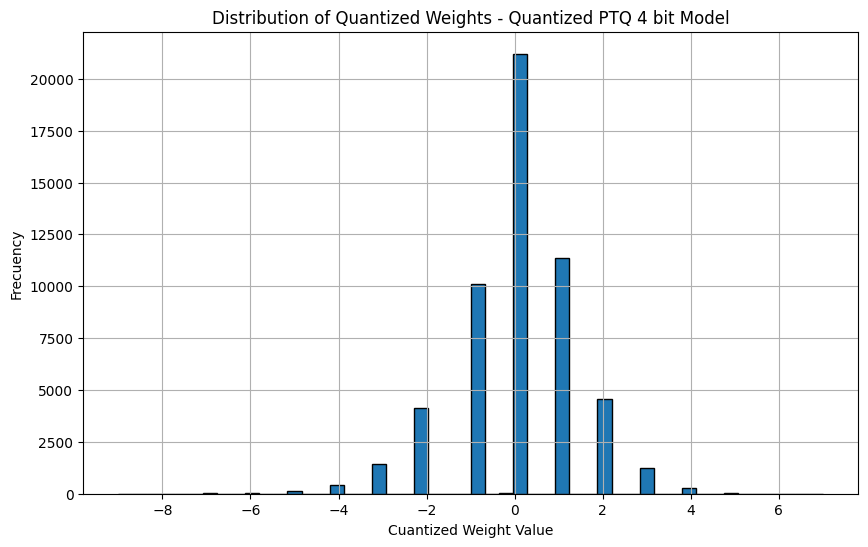

In [23]:
def show_sim_quantized_weights(network, title):
    quantized_weights = []
    for param in network.parameters():
        if param.requires_grad:
            quantized_weights.extend(param.detach().cpu().numpy().flatten())

    plt.figure(figsize=(10, 6))
    plt.hist(quantized_weights, bins=50, edgecolor='black')
    plt.title('Distribution of Quantized Weights - {}'.format(title))
    plt.xlabel('Cuantized Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_sim_quantized_weights(ptq_model_4bit,"Quantized PTQ 4 bit Model")

El tamaño final de la red quantizada mediante PTQ es igual a la de la red normal, debido a que no se está quantizando realmente

In [24]:
float_model_size = os.path.getsize('./models/MNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/MNIST/ptq_model_4bit_sim.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 0.213MB
Quantized model: 0.213MB


In [25]:
def save_model(network):
    quantized_model = SimpleNN()
    for name, param in network.named_parameters():
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            setattr(layer, param_type, nn.Parameter(param.data.to(torch.int8),False))

    return quantized_model

def load_model(network):
    quantized_model = SimpleNN()
    for name, param in network.named_parameters():
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            setattr(layer, param_type, nn.Parameter(param.data.to(torch.float32),False))

    return quantized_model

In [26]:
torch.save(save_model(ptq_model_4bit).state_dict(), 'models/MNIST/ptq_model_4bit.pth')

In [27]:
float_model_size = os.path.getsize('./models/MNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/MNIST/ptq_model_4bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 0.213MB
Quantized model: 0.055MB


## Quantization Aware Training propio (4 bits)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [29]:
class QuantAwareNN(nn.Module):
    def __init__(self):
        super(QuantAwareNN, self).__init__()
        self.quant = quantization.QuantStub()
        self.li = nn.Linear(28*28,64)
        self.l1 = nn.Linear(64,64)
        self.lf = nn.Linear(64,10)
        self.dequant = quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = x.view(-1, 28*28)
        x = torch.relu(self.li(x))
        x = torch.relu(self.l1(x))
        x = self.lf(x)
        x = self.dequant(x)
        return x

In [30]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
bits = 4

act = FakeQuantize.with_args(observer=MovingAverageMinMaxObserver, quant_min=0, quant_max=int(2 ** bits - 1), dtype=torch.quint8, qscheme=torch.per_tensor_affine, reduce_range=False)
weights = FakeQuantize.with_args(observer=MovingAveragePerChannelMinMaxObserver, quant_min=int(-(2 ** bits) / 2), quant_max=int((2 ** bits) / 2 - 1), dtype=torch.qint8, qscheme=torch.per_channel_symmetric, reduce_range=False)

qat_model_4bit = QuantAwareNN()

qat_model_4bit.qconfig = quantization.get_default_qat_qconfig('x86')
qat_model_4bit.qconfig = quantization.qconfig.QConfig(activation=act, weight=weights)
qat_model_4bit = quantization.prepare_qat(qat_model_4bit)

In [32]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    qat_model_4bit.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = qat_model_4bit(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

def validate():
    qat_model_4bit.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = qat_model_4bit(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [33]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model_4bit.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.313340
Train Epoch: 0 [23936/48000 (50%)]	Loss: 0.192909
Train Epoch: 0 [47872/48000 (100%)]	Loss: 0.269302

Validation Set Accuracy: 11042/12000 (92.02%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.474402
Train Epoch: 1 [23936/48000 (50%)]	Loss: 0.138512
Train Epoch: 1 [47872/48000 (100%)]	Loss: 0.315859

Validation Set Accuracy: 11220/12000 (93.50%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.152092
Train Epoch: 2 [23936/48000 (50%)]	Loss: 0.113583
Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.149609

Validation Set Accuracy: 11372/12000 (94.77%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.088673
Train Epoch: 3 [23936/48000 (50%)]	Loss: 0.128139
Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.090395

Validation Set Accuracy: 11318/12000 (94.32%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.085552
Train Epoch: 4 [23936/48000 (50%)]	Loss: 0.198257
Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.118300

Validation Set Accuracy: 11432/12000 (95.27%)

Train Epoch: 5 [0/48000 (0%)]	

In [34]:
qat_model_4bit.eval()
qat_model_4bit = quantization.convert(qat_model_4bit)

torch.save(qat_model_4bit.state_dict() , './models/MNIST/qat_model_4bit.pth')
test(qat_model_4bit, criteria)


Test set: Avg. loss: 0.002127, Accuracy: 9566/10000 (95.66%)



In [35]:
float_model_size = os.path.getsize('./models/MNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/MNIST/qat_model_4bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 0.213MB
Quantized model: 0.061MB


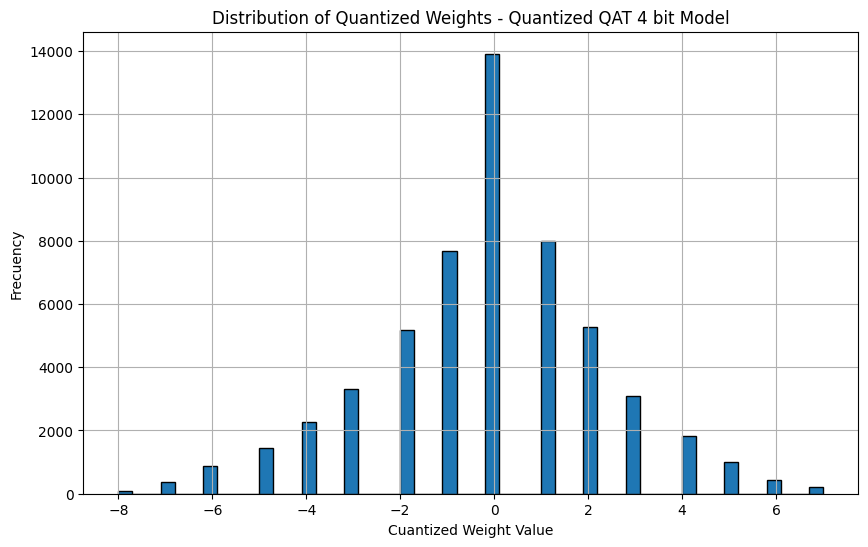

In [36]:
show_quantized_weights(qat_model_4bit,"Quantized QAT 4 bit Model")